## [MFCC](http://recognize-speech.com/feature-extraction/mfcc)

https://www.youtube.com/watch?v=Xjzm7S__kBU&list=PLA480D1979B10D8F5

We will give a high level intro to the implementation steps, then go in depth why we do the things we do. Towards the end we will go into a more detailed description of how to calculate MFCCs.
> 
+ Frame the signal into short frames.
+ For each frame calculate the periodogram estimate of the power spectrum.
+ Apply the mel filterbank to the power spectra, sum the energy in each filter.
+ Take the logarithm of all filterbank energies.
+ Take the DCT of the log filterbank energies.
+ Keep DCT coefficients 2-13, discard the rest.

[Sampling](https://en.wikipedia.org/wiki/Sampling_(signal_processing))

[speaker-identification-using-pitch-and-mfcc](https://in.mathworks.com/help/audio/examples/speaker-identification-using-pitch-and-mfcc.html?requestedDomain=true)

[practicalcryptography](http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)

[data](https://medium.com/@klintcho/creating-an-open-speech-recognition-dataset-for-almost-any-language-c532fb2bc0cf)

## Mel-Frequency Cepstrum Coefficients (MFCC)

Mel-Frequency Cepstrum Coefficients (MFCC) are popular features extracted from speech signals for use in recognition tasks. In the source-filter model of speech, MFCCs are understood to represent the filter (vocal tract). The vocal tract frequency response is relatively smooth, whereas the source of voiced speech can be modeled as an impulse train. The result is that the vocal tract can be estimated by the spectral envelope of a speech segment.

The motivating idea of MFCC is to compress information about the vocal tract (smoothed spectrum) into a small number of coefficients based on an understanding of the cochlea.

Although there is no hard standard for calculating MFCC, the basic steps are outlined by the diagram.

![](https://in.mathworks.com/help/examples/audio_product/win64/SpeakerID02.png)


Mel filter bank is important due to following reasons:
> 
+ It applies the Mel-frequency scaling, which is perceptual scale that helps to simulate the way human ear works. It corresponds to better resolution at low frequencies and less at high.
+ Using the triangular filter-bank helps to capture the energy at each critical band and gives a rough approximation of the spectrum shape, as well as smooths the harmonic structure. In theory you could manipulate on raw DFT bins, but then you are not reducing the dimensionality of your features - this is the whole point of doing filter-bank analysis, to capture the spectral envelope.

Obviously warping of frequency scale can be altered. Other mappings are possible, such as Bark, linear, etc. Mel is just one out of many options. To finalize, you can always calculate more filter-banks to have coarser scale (getting closer to actual DFT), but you will notice that at some point it will degrade the performance and your features do not carry essential information

[MFCC - Significance of number of features](https://dsp.stackexchange.com/questions/28898/mfcc-significance-of-number-of-features)

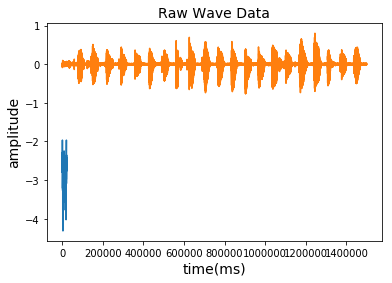

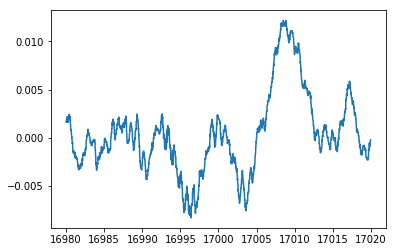

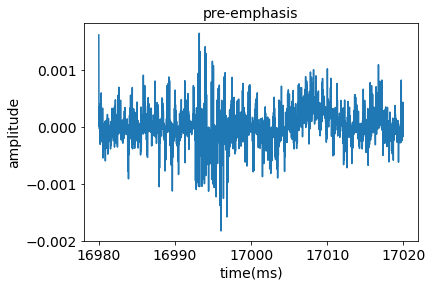

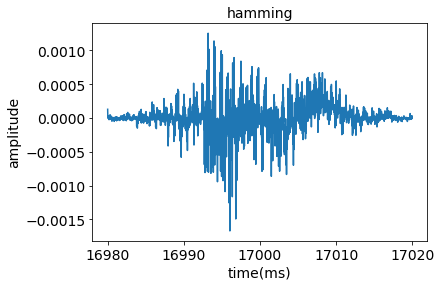

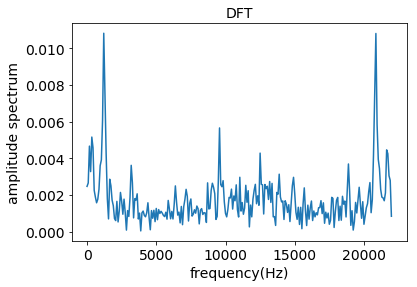

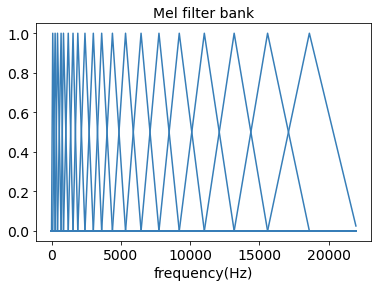

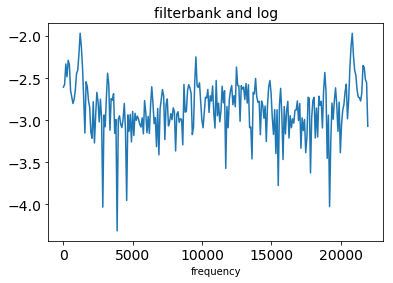

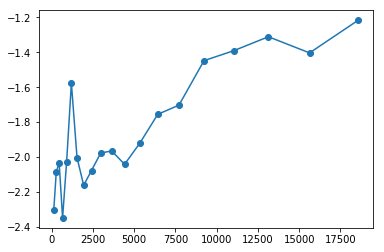

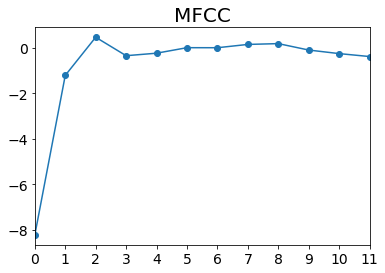

[-8.217184906564318, -1.2076720757589492, 0.4680950704018078, -0.34291844004249983, -0.23261121353757558, 0.009392147279069911, 0.007722294976729393, 0.15266981252520526, 0.18781933674060142, -0.09437062557209616, -0.25096052684348114, -0.3800933186877112]


In [5]:
import wave
import numpy as np
import scipy.signal
import scipy.fftpack
import scipy.fftpack.realtransforms
import math
import sys
import matplotlib.pyplot as plt

def wavread(filename):
    wf = wave.open(filename, "r")
    fs = wf.getframerate()
    buf = wf.readframes(wf.getnframes())
    data = np.frombuffer(buf, dtype="int16") / 32768.0  # (-1, 1)に正規化

    plt.plot(data)
    plt.title("Raw Wave Data",fontsize=14)
    plt.xlabel("time(ms)",fontsize=14)
    plt.ylabel("amplitude",fontsize=14)
    plt.show()
    wf.close()
    return data, float(fs)

def hz2mel(f):
    return 1127.01048 * math.log(f / 700.0 + 1.0)

def mel2hz(m):
    return 700.0 * (np.exp(m / 1127.01048) - 1.0)

def melFilterBank(fs, nfft, numChannels):
    fmax = fs / 2
    melmax = hz2mel(fmax)
    nmax = int(nfft / 2)
    df = fs / nfft
    dmel = melmax / (numChannels + 1)
    melcenters = np.arange(1, numChannels + 1) * dmel
    fcenters = mel2hz(melcenters)
    indexcenter = np.round(fcenters / df)
    indexstart = np.hstack(([0], indexcenter[0:numChannels - 1]))
    indexstop = np.hstack((indexcenter[1:numChannels], [nmax]))

    filterbank = np.zeros((numChannels, nmax))

    for c in np.arange(0, numChannels):
        increment= 1.0 / (indexcenter[c] - indexstart[c])
        
        for i in np.arange(indexstart[c], indexcenter[c]):
            i=int(i)
            filterbank[c, i] = (i - indexstart[c]) * increment
        decrement = 1.0 / (indexstop[c] - indexcenter[c])
        
        for i in np.arange(indexcenter[c], indexstop[c]):
            i=int(i)
            filterbank[c, i] = 1.0 - ((i - indexcenter[c]) * decrement)

    return filterbank, fcenters

def preEmphasis(signal, p):
    return scipy.signal.lfilter([1.0, -p], 1, signal)

def mfcc(signal, nfft, fs, nceps,time):

    p = 0.97
    signal = preEmphasis(signal, p)
    plotDivideWav(time, signal,"pre-emphasis")

    hammingWindow = np.hamming(len(signal))
    signal = signal * hammingWindow
    plotDivideWav(time,signal,"hamming")

    spec = np.abs(np.fft.fft(signal, nfft))[:(int)(nfft/2)]
    fscale = np.fft.fftfreq(nfft, d = 1.0 / fs)[:(int)(nfft/2)]
    plt.plot(fscale,spec)
    plt.title("DFT",fontsize=14)
    plt.xlabel("frequency(Hz)",fontsize=14)
    plt.ylabel("amplitude spectrum",fontsize=14)
    plt.tick_params(labelsize=14)
    plt.show()

    numChannels = 20
    df = fs / nfft
    filterbank, fcenters = melFilterBank(fs, nfft, numChannels)

    for c in np.arange(0, numChannels):
        plt.plot(np.arange(0, nfft / 2) * df, filterbank[c],color="#377eb8")
    plt.title("Mel filter bank",fontsize=14)
    plt.xlabel("frequency(Hz)",fontsize=14)
    plt.tick_params(labelsize=14)
    plt.show()

    mspec = np.log10(np.dot(spec, filterbank.T))

    plt.plot(fscale,np.log10(spec))
    plt.title("filterbank and log",fontsize=14)
    plt.xlabel("frequency")
    plt.tick_params(labelsize=14)
    plt.show()

    plt.plot(fcenters,mspec,"o-")
    plt.show()

    ceps = scipy.fftpack.realtransforms.dct(mspec, type=2, norm="ortho", axis=-1)
    axis_x = np.arange(12)
    plt.plot(ceps,"o-")
    plt.xticks(axis_x)
    plt.xlim([0,11])
    plt.title("MFCC",fontsize=20)
    plt.tick_params(labelsize=14)
    plt.show()
    
    return ceps[:nceps]

def mfcc2(signal, nfft, fs, nceps,time):
    p = 0.97
    signal = preEmphasis(signal, p)

    hammingWindow = np.hamming(len(signal))
    plt.plot(hammingWindow)
    plt.show()
    signal = signal * hammingWindow
    plt.plot(signal)
    plt.show()
    
    spec = np.abs(np.fft.fft(signal, nfft))[:(int)(nfft/2)]
    fscale = np.fft.fftfreq(nfft, d = 1.0 / fs)[:(int)(nfft/2)]

    numChannels = 20
    df = fs / nfft
    filterbank, fcenters = melFilterBank(fs, nfft, numChannels)
    
    """
    メルフィルタバンクの描画
    for c in np.arange(0, numChannels):
        plt.plot(np.arange(0, nfft / 2) * df, filterbank[c])
    plt.show()
    """
    
    mspec = np.log10(np.dot(spec, filterbank.T))
    
    ceps = scipy.fftpack.realtransforms.dct(mspec, type=2, norm="ortho", axis=-1)
    plt.plot(ceps)
    plt.show()

    return ceps[:nceps]

def get_feature(wavfile,nfft,nceps):
    wav, fs = wavread(wavfile)
    t = np.arange(0.0, len(wav) / fs, 1/fs)
    
    center = len(wav) / 2
    cuttime = 0.04
    wavdata = wav[int(center - cuttime/2*fs) : int(center + cuttime/2*fs)]
    time = t[int(center - cuttime/2*fs) : int(center + cuttime/2*fs)]
    plt.plot(time * 1000, wavdata)
    plt.show()

    ceps = mfcc(wavdata, nfft, fs, nceps,time)
    return ceps.tolist()


def plotDivideWav(time, wav, title):
    plt.plot(time * 1000, wav)
    plt.title(title,fontsize=14)
    plt.xlabel("time(ms)",fontsize=14)
    plt.ylabel("amplitude",fontsize=14)
    plt.tick_params(labelsize=14)
    plt.show()


if __name__ == "__main__":
    
    #read wavfile from commnadline(args[1])
#     args = sys.argv
#     wavfile = args[1]

    #for i in range(5):
    #    n = i
    #    s = args[1] + '_' + str(n) + '.wav'

    #    wavfile = wavread(s)

    wavfile = "arun.wav"
    nfft=512
    nceps=12
    tmp=get_feature(wavfile,nfft,nceps)
    

    #f = open('data.txt','w')
    #f.write(str(tmp))
    #f.close()
    print(tmp)

In [2]:
import math
import numpy as np
from scipy.fftpack import dct


def _hz2mel(hz):
    """
    Convert frequency to Mel frequency.
    Arguments:
        hz:Frequency in Hz.
    Returns:
        Mel frequency.
    """
    return 2595 * np.log10(1 + hz / 700.0)


def _mel2hz(mel):
    """
    Convert Mel frequency to frequency.
    Arguments:
        mel:Mel frequency
    Returns:
        Frequency in Hz.
    """
    return 700 * (10**(mel / 2595.0) - 1)


def _spectrum_magnitude(frames, NFFT):
    '''
    Apply FFT and Calculate magnitude of the spectrum.
    Arguments:
        frames: 2-D frames array calculated by audio2frame(...).
        NFFT:FFT size.
    Returns:
        Return magnitude of the spectrum after FFT, with shape (frames_num, NFFT).
    '''
    complex_spectrum = np.fft.rfft(frames, NFFT)
    return np.absolute(complex_spectrum)


def _spectrum_power(frames, NFFT):
    """
    Calculate power spectrum for every frame after FFT.
    Arguments:
        frames: 2-D frames array calculated by audio2frame(...).
        NFFT:FFT size
    Returns:
        Power spectrum: PS = magnitude^2/NFFT
    """
    return 1.0/NFFT * np.square(_spectrum_magnitude(frames, NFFT))


def _pre_emphasis(signal, coefficient=0.95):
    '''
    Pre-emphasis.
    Arguments:
        signal: 1-D numpy array.
        coefficient:Coefficient for pre-emphasis. Defauted to 0.95.
    Returns:
        pre-emphasis signal.
    '''
    return np.append(signal[0], signal[1:] - coefficient * signal[:-1])


def _audio2frame(signal, frame_length, frame_step, win_func=lambda x:np.ones((x,))):
    """
    Framing audio signal. Uses numbers of samples as unit.
    Arguments:
        signal: 1-D numpy array.
        frame_length: In this situation, frame_length=sample_rate*win_length, since we use numbers of samples as unit.
        frame_step:In this situation, frame_step = sample_rate*win_step, 
                   representing the number of samples between the start point of adjacent frames.
        win_func:lambda function, to generate a vector with shape (x,) filled with ones.
    Returns:
        frames*win: 2-D numpy array with shape (frames_num, frame_length).
    """
    signal_length = len(signal)
    # Use round() to ensure length and step are integer, considering that we use numbers of samples as unit.
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    if signal_length <= frame_length:
        frames_num = 1
    else:
        frames_num = 1 + int(math.ceil((signal_length - frame_length) / frame_step))
    pad_length = int((frames_num - 1) * frame_step + frame_length)
    # Padding zeros at the end of signal if pad_length > signal_length.
    zeros = np.zeros((pad_length - signal_length, ))
    pad_signal = np.concatenate((signal, zeros))
    # Calculate the indices of signal for every sample in frames, shape (frams_nums, frams_length)
    indices = np.tile(np.arange(0, frame_length), (frames_num, 1)) + np.tile(np.arange(0, frames_num * frame_step, frame_step), 
                                                                             (frame_length, 1)).T
    indices = np.array(indices, dtype=np.int32)
    # Get signal data according to indices.
    frames = pad_signal[indices]
    win = np.tile(win_func(frame_length), (frames_num, 1))
    return frames*win


def _lifter(cepstra, L=22):
    '''
    Lifter function.
    Arguments:
        cepstra: MFCC coefficients.
        L: Numbers of lifters. Defaulted to 22.
    '''
    if L > 0:
        (nframes, ncoeff) = np.shape(cepstra)
        n = np.arange(ncoeff)
        lift = 1+(L/2)*np.sin(np.pi*n/L)
        return lift*cepstra
    else:
        return cepstra


def _get_filter_banks(filters_num=20, NFFT=512, sample_rate=16000, low_freq=0, high_freq=None):
    '''
    Calculate Mel filter banks.
    Arguments:
        filters_num: Numbers of Mel filters.
        NFFT:FFT size. Defaulted to 512.
        sample_rate: Sampling rate. Defaulted to 16KHz.
        low_freq: Lowest frequency.
        high_freq: Highest frequency.
    '''
    # Convert frequency to Mel frequency.
    low_mel = _hz2mel(low_freq)
    high_mel = _hz2mel(high_freq)
    # Insert filters_num of points between low_mel and high_mel. In total there are filters_num+2 points
    mel_points = np.linspace(low_mel, high_mel, filters_num + 2)
    # Convert Mel frequency to frequency and find corresponding position.
    hz_points = _mel2hz(mel_points)
    # Find corresponding position of these hz_points in fft.
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)
    # Build Mel filters' expression.First and third points of each filter are zeros.
    fbank = np.zeros([filters_num, int(NFFT / 2 + 1)])
    for j in range(0, filters_num):
        for i in range(int(bin[j]), int(bin[j+1])):
            fbank[j,i] = (i-bin[j]) / (bin[j+1]-bin[j])
        for i in range(int(bin[j+1]), int(bin[j+2])):
            fbank[j,i] = (bin[j+2]-i) / (bin[j+2]-bin[j+1])
    return fbank


def _fbank(signal, sample_rate=16000, win_length=0.025, win_step=0.01, filters_num=26,
           NFFT=512, low_freq=0, high_freq=None, pre_emphasis_coeff=0.97):
    """
    Perform pre-emphasis -> framing -> get magnitude -> FFT -> Mel Filtering.
    Arguments:
        signal: 1-D numpy array.
        sample_rate: Sampling rate. Defaulted to 16KHz.
        win_length: Window length. Defaulted to 0.025, which is 25ms/frame.
        win_step: Interval between the start points of adjacent frames.
            Defaulted to 0.01, which is 10ms.
        filters_num: Numbers of filters. Defaulted to 26.
        NFFT: Size of FFT. Defaulted to 512.
        low_freq: Lowest frequency.
        high_freq: Highest frequency.
        pre_emphasis_coeff: Coefficient for pre-emphasis. Pre-emphasis increase
            the energy of signal at higher frequency. Defaulted to 0.97.
    Returns:
        feat: Features.
        energy: Energy.
    """
    # Calculate the highest frequency.
    high_freq = high_freq or sample_rate / 2
    # Pre-emphasis
    signal = _pre_emphasis(signal, pre_emphasis_coeff)
    # frames: 2-D numpy array with shape (frame_num, frame_length)
    frames = _audio2frame(signal, win_length * sample_rate, win_step * sample_rate)
    # Caculate energy and modify all zeros to eps.
    spec_power = _spectrum_power(frames, NFFT)
    energy = np.sum(spec_power, 1)
    energy = np.where(energy==0, np.finfo(float).eps, energy)
    # Get Mel filter banks.
    fb = _get_filter_banks(filters_num, NFFT, sample_rate, low_freq, high_freq)
    # Get MFCC and modify all zeros to eps.
    feat = np.dot(spec_power, fb.T)
    feat = np.where(feat==0, np.finfo(float).eps, feat)

    return feat, energy


def _delta(feat, N=2):
    """
    Compute delta features from a feature vector sequence.
    Arguments:
        feat: A numpy array of size (NUMFRAMES by number of features) containing features.
        Each row holds 1 feature vector.
        N: For each frame, calculate delta features based on preceding and following N frames.
    Returns:
        A numpy array of size (NUMFRAMES by number of features) containing delta features.
        Each row holds 1 delta feature vector.
    """
    NUMFRAMES = len(feat)
    feat = np.concatenate(([feat[0] for i in range(N)], feat, [feat[-1] for i in range(N)]))
    denom = sum([2*i*i for i in range(1, N+1)])
    dfeat = []
    for j in range(NUMFRAMES):
        dfeat.append(np.sum([n*feat[N+j+n] for n in range(-1*N, N+1)], axis=0)/denom)
    return dfeat


def calcFbank(signal, sample_rate=16000, win_length=0.025, win_step=0.01,
             filters_num=26, NFFT=512, low_freq=0, high_freq=None, pre_emphasis_coeff=0.97,
             append_energy=True, append_delta=False):
    """
    Calculate Fbank Features.
    Arguments:
        signal: 1-D numpy array.
        sample_rate: Sampling rate. Defaulted to 16KHz.
        win_length: Window length. Defaulted to 0.025, which is 25ms/frame.
        win_step: Interval between the start points of adjacent frames.
            Defaulted to 0.01, which is 10ms.
        filters_num: Numbers of filters. Defaulted to 26.
        NFFT: Size of FFT. Defaulted to 512.
        low_freq: Lowest frequency.
        high_freq: Highest frequency.
        pre_emphasis_coeff: Coefficient for pre-emphasis. Pre-emphasis increase
            the energy of signal at higher frequency. Defaulted to 0.97.
        append_energy: Whether to append energy. Defaulted to True.
        append_delta: Whether to append delta to feature. Defaulted to False.
    Returns:
        2-D numpy array with shape (NUMFRAMES, features). Each frame containing filters_num of features.
    """
    (feat, energy) = _fbank(signal, sample_rate, win_length, win_step, filters_num, NFFT,
                           low_freq, high_freq, pre_emphasis_coeff)
    feat = np.log(feat)
    if append_energy:
        feat[:, 0] = np.log(energy)
    if append_delta:
        feat_delta = _delta(feat)
        feat_delta_delta = _delta(feat_delta)
        feat = np.concatenate((feat, feat_delta, feat_delta_delta), axis=1)

    return feat


def calcMFCC(signal, sample_rate=16000, win_length=0.025, win_step=0.01,
             filters_num=26, NFFT=512, low_freq=0, high_freq=None, pre_emphasis_coeff=0.97,
             cep_lifter=22, append_energy=True, append_delta=False):
    """
    Calculate MFCC Features.
    Arguments:
        signal: 1-D numpy array.
        sample_rate: Sampling rate. Defaulted to 16KHz.
        win_length: Window length. Defaulted to 0.025, which is 25ms/frame.
        win_step: Interval between the start points of adjacent frames.
            Defaulted to 0.01, which is 10ms.
        filters_num: Numbers of filters. Defaulted to 26.
        NFFT: Size of FFT. Defaulted to 512.
        low_freq: Lowest frequency.
        high_freq: Highest frequency.
        pre_emphasis_coeff: Coefficient for pre-emphasis. Pre-emphasis increase
            the energy of signal at higher frequency. Defaulted to 0.97.
        cep_lifter: Numbers of lifter for cepstral. Defaulted to 22.
        append_energy: Whether to append energy. Defaulted to True.
        append_delta: Whether to append delta to feature. Defaulted to False.
    Returns:
        2-D numpy array with shape (NUMFRAMES, features). Each frame containing filters_num of features.
    """
    (feat, energy) = _fbank(signal, sample_rate, win_length, win_step, filters_num, NFFT,
                           low_freq, high_freq, pre_emphasis_coeff)
    feat = np.log(feat)
    feat = dct(feat, type=2, axis=1, norm='ortho')
    feat = _lifter(feat, cep_lifter)
    if append_energy:
        feat[:, 0] = np.log(energy)
    if append_delta:
        feat_delta = _delta(feat)
        feat_delta_delta = _delta(feat_delta)
        feat = np.concatenate((feat, feat_delta, feat_delta_delta), axis=1)

    return feat

In [56]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import scipy.signal
import matplotlib.pyplot as plt
import os.path
import math
from __future__ import division


In [57]:
def Plot(time, wav, title):
    plt.plot(time * 1000, wav)
    plt.title(title,fontsize=14)
    plt.xlabel("time(ms)",fontsize=14)
    plt.ylabel("amplitude",fontsize=14)
    plt.tick_params(labelsize=14)
    plt.show()

In [58]:
def wavread(filename):
    rate, data = scipy.io.wavfile.read(filename)
    signal_len = len(data)
    plt.plot(data)
    plt.title("Raw Wave Data",fontsize=14)
    plt.xlabel("time(ms)",fontsize=14)
    plt.ylabel("amplitude",fontsize=14)
    plt.show()
    return data, float(rate)


In [59]:
def hz2mel(hz):
    """
    Convert frequency to Mel frequency.
    Arguments:
        hz:Frequency in Hz.
    Returns:
        Mel frequency.
    """
    return 1127.01048 * math.log(hz / 700.0 + 1.0)
#     return 2595 * np.log10(1 + hz / 700.0)   # 1125 * np.log(1 + hz / 700.0)


In [60]:
def mel2hz(mel):
    """
    Convert Mel frequency to frequency.
    Arguments:
        mel:Mel frequency
    Returns:
        Frequency in Hz.
    """
    return 700.0 * (np.exp(mel / 1127.01048) - 1.0)
#     return 700 * (10**(mel / 2595.0) - 1)


In [61]:
def preEmphasis(signal, p):
    '''
    Pre-emphasis.
    Arguments:
        signal: 1-D numpy array.
        coefficient:Coefficient for pre-emphasis. Defauted to 0.95.
    Returns:
        pre-emphasis signal.
    '''
    return scipy.signal.lfilter([1.0, -p], 1, signal)
#     return np.append(signal[0], signal[1:] - coefficient * signal[:-1])

In [62]:
def melFilterBank(fs, nfft, numChannels):
    fmax = fs / 2
    melmax = hz2mel(fmax)
    nmax = int(nfft / 2)
    df = fs / nfft
    dmel = melmax / (numChannels + 1)
    melcenters = np.arange(1, numChannels + 1) * dmel
    fcenters = mel2hz(melcenters)
    indexcenter = np.round(fcenters / df)
    indexstart = np.hstack(([0], indexcenter[0:numChannels - 1]))
    indexstop = np.hstack((indexcenter[1:numChannels], [nmax]))

    filterbank = np.zeros((numChannels, nmax))

    for c in np.arange(0, numChannels):
        increment= 1.0 / (indexcenter[c] - indexstart[c])
        
        for i in np.arange(indexstart[c], indexcenter[c]):
            i=int(i)
            filterbank[c, i] = (i - indexstart[c]) * increment
        decrement = 1.0 / (indexstop[c] - indexcenter[c])
        
        for i in np.arange(indexcenter[c], indexstop[c]):
            i=int(i)
            filterbank[c, i] = 1.0 - ((i - indexcenter[c]) * decrement)

    return filterbank, fcenters

In [63]:
def mfcc(signal, nfft, fs, nceps,time):

    p = 0.97
    signal = preEmphasis(signal, p)
    Plot(time, signal,"pre-emphasis")

    hammingWindow = np.hamming(len(signal))
    signal = signal * hammingWindow
    Plot(time,signal,"hamming")

    spec = np.abs(np.fft.fft(signal, nfft))[:(int)(nfft/2)]
    fscale = np.fft.fftfreq(nfft, d = 1.0 / fs)[:(int)(nfft/2)]
    plt.plot(fscale,spec)
    plt.title("DFT",fontsize=14)
    plt.xlabel("frequency(Hz)",fontsize=14)
    plt.ylabel("amplitude spectrum",fontsize=14)
    plt.tick_params(labelsize=14)
    plt.show()

    numChannels = 20
    df = fs / nfft
    filterbank, fcenters = melFilterBank(fs, nfft, numChannels)

    for c in np.arange(0, numChannels):
        plt.plot(np.arange(0, nfft / 2) * df, filterbank[c],color="#377eb8")
    plt.title("Mel filter bank",fontsize=14)
    plt.xlabel("frequency(Hz)",fontsize=14)
    plt.tick_params(labelsize=14)
    plt.show()

    mspec = np.log10(np.dot(spec, filterbank.T))

    plt.plot(fscale,np.log10(spec))
    plt.title("filterbank and log",fontsize=14)
    plt.xlabel("frequency")
    plt.tick_params(labelsize=14)
    plt.show()

    plt.plot(fcenters,mspec,"o-")
    plt.show()

    ceps = scipy.fftpack.realtransforms.dct(mspec, type=2, norm="ortho", axis=-1)
    axis_x = np.arange(12)
    plt.plot(ceps,"o-")
    plt.xticks(axis_x)
    plt.xlim([0,11])
    plt.title("MFCC",fontsize=20)
    plt.tick_params(labelsize=14)
    plt.show()
    
    return ceps[:nceps]


In [64]:
def get_feature(wavfile,nfft,nceps):
    wav, fs = wavread(wavfile)
    t = np.arange(0.0, len(wav) / fs, 1/fs)
    
    center = len(wav) / 2
    cuttime = 0.04
    wavdata = wav[int(center - cuttime/2*fs) : int(center + cuttime/2*fs)]
    time = t[int(center - cuttime/2*fs) : int(center + cuttime/2*fs)]
    Plot(time, wavdata,"Raw Wave Data")

    ceps = mfcc(wavdata, nfft, fs, nceps,time)
    return ceps.tolist()


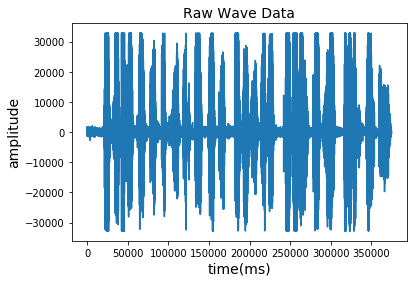

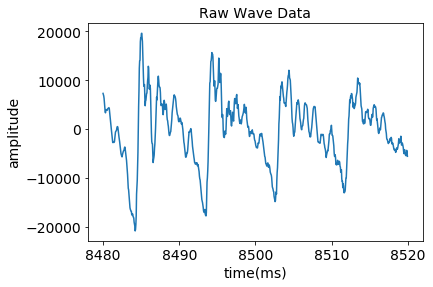

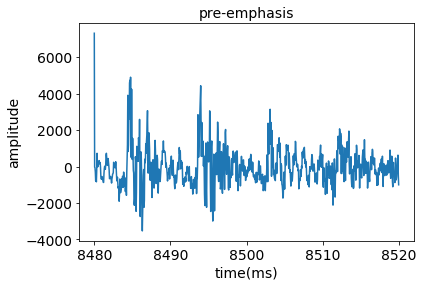

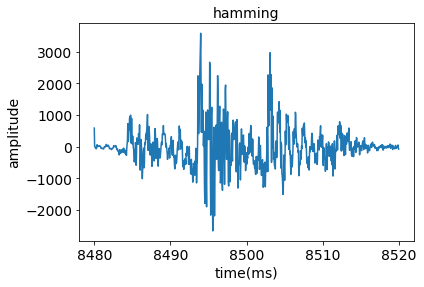

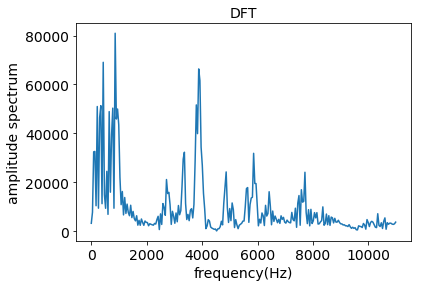

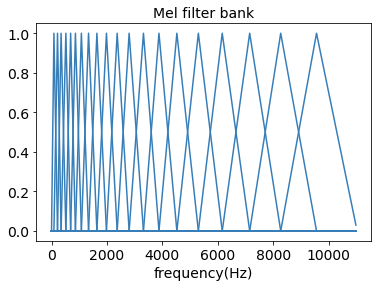

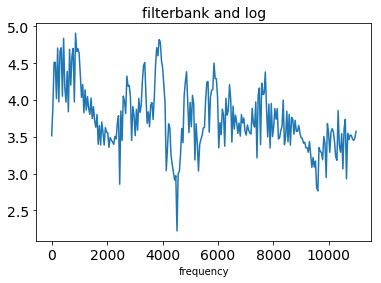

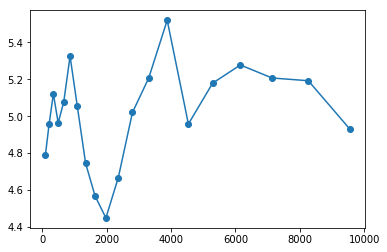

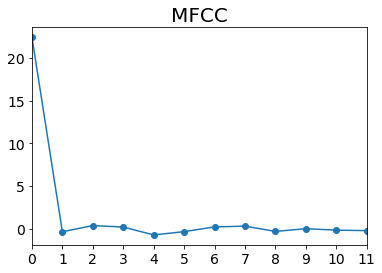

[22.40655194170767, -0.34740377819886886, 0.3828029938191853, 0.20664894976095607, -0.713089759104896, -0.3322847537744077, 0.2216329034491885, 0.31300554757827526, -0.30262914576137384, 0.01625857484262747, -0.155007208889876, -0.21195284923237184]


In [65]:


if __name__ == "__main__":
    
    SAMPLE_DIR = 'audio_samples/'
    files = next(os.walk(SAMPLE_DIR))[2]
    files = list(files)
    
    wavfile = SAMPLE_DIR + files[0]
    nfft = 512
    nceps = 12
    tmp=get_feature(wavfile,nfft,nceps)
    
    print(tmp)
    




# 2.



http://python-speech-features.readthedocs.io/en/latest/

In [66]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt
import os.path
from __future__ import division

SAMPLE_DIR = 'audio_samples/'
files = next(os.walk(SAMPLE_DIR))[2]
files = list(files)
files

['andrew.wav',
 'arun.wav',
 'a_45.wav',
 'LDC93S1.wav',
 'mitha.wav',
 'mixed1.wav',
 'overlay.wav',
 'test.wav']

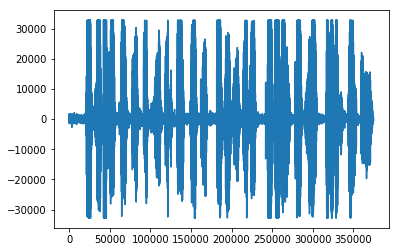

22050

In [67]:
# rate : int(Sample rate of wav file)
# data : numpy array(Data read from wav file)

rate, signal = scipy.io.wavfile.read(SAMPLE_DIR + files[0])
signal_len = len(signal)
plt.plot(signal)
plt.show()
rate

In [68]:
frame_size = (20 / 1000) * rate
frame_advance = (10 / 1000) * rate

frame_size = int(round(frame_size))
frame_advance = int(round(frame_advance))

frame_size, frame_advance

(441, 221)

In [69]:
num_frames = int(np.ceil(float(np.abs(signal_len - frame_size)) / frame_advance))
num_frames

1695

In [70]:
pad_signal_length = num_frames * frame_advance + frame_size
z = np.zeros((int(pad_signal_length) - signal_len))
pad_signal = np.append(signal, z)
pad_signal, z

(array([-730., -688., -640., ...,    0.,    0.,    0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,

The Hamming window is defined as

![](https://docs.scipy.org/doc/numpy/_images/math/362db3689e82c2578b0250ee977af827bfed59c8.svg)

The window, with the maximum value normalized to one (the value one appears only if the number of samples is odd).

The Hamming was named for R. W. Hamming, an associate of J. W. Tukey and is described in Blackman and Tukey. It was recommended for smoothing the truncated autocovariance function in the time domain. Most references to the Hamming window come from the signal processing literature, where it is used as one of many windowing functions for smoothing values. It is also known as an apodization (which means “removing the foot”, i.e. smoothing discontinuities at the beginning and end of the sampled signal) or tapering function.

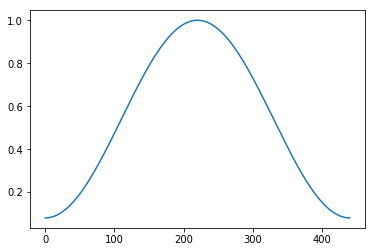

In [71]:
plt.plot(np.hamming(frame_size))
plt.show()

In [72]:
indices = np.tile(np.arange(0, frame_size), (num_frames, 1)) + np.tile(
    np.arange(0, num_frames * frame_advance, frame_advance), (frame_size, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]
frames *= np.hamming(frame_size)
frames

array([[-58.4       , -55.07226735, -51.32005843, ...,  36.40516645,
         36.5013865 ,  37.6       ],
       [-17.92      , -16.08942694, -12.34888906, ..., -45.78711463,
        -49.62907813, -50.48      ],
       [ 30.32      ,  31.29833798,  26.06096717, ...,  12.74982702,
          9.68567493,   9.84      ],
       ..., 
       [ 24.88      ,  15.28895794,  17.96202045, ..., -68.88114093,
        -62.03634767, -57.92      ],
       [-53.2       , -52.43071964, -42.65979857, ...,  -6.33481971,
         -3.12182911,   2.16      ],
       [-55.84      , -60.11522206, -61.7444453 , ..., -14.43376643,
        -11.60680053,  -8.48      ]])

In [73]:
nfft = 2048       # the FFT size
cep = 12          # the number of cepstrum to return
num_filters = 40  # the number of filters in the filterbank

sanderson_filters = np.array([200, 300, 400, 500, 600, 700, 800, 900, 1000, 1149, 1320, 1516, 1741, 2000, 2297, 2639, 3031, 3482, 4000])

In [74]:
central_freqs = sanderson_filters[1:-1] # Remove o inicial e final, mantendo apenas os centrais
central_freqs

array([ 300,  400,  500,  600,  700,  800,  900, 1000, 1149, 1320, 1516,
       1741, 2000, 2297, 2639, 3031, 3482])

In [75]:
nfilt = len(central_freqs)
bin = np.floor((nfft + 1) * sanderson_filters / rate)
bin

array([  18.,   27.,   37.,   46.,   55.,   65.,   74.,   83.,   92.,
        106.,  122.,  140.,  161.,  185.,  213.,  245.,  281.,  323.,  371.])

In [76]:
fbank = np.zeros((nfilt, int(np.floor(nfft / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])  # initial
    f_m = int(bin[m])  # central
    f_m_plus = int(bin[m + 1])  # final

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


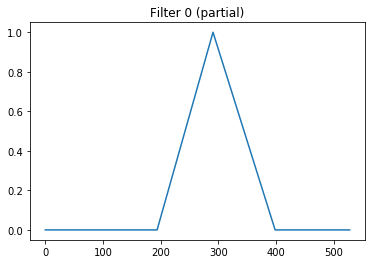

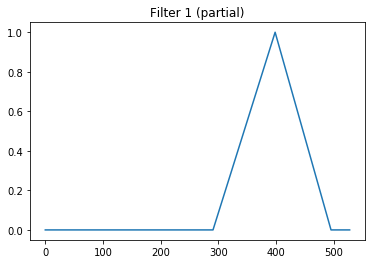

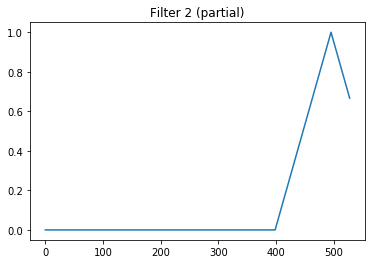

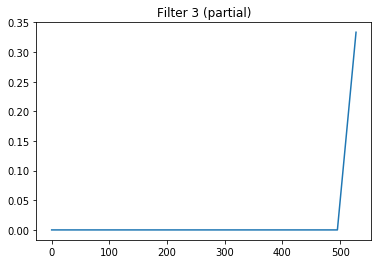

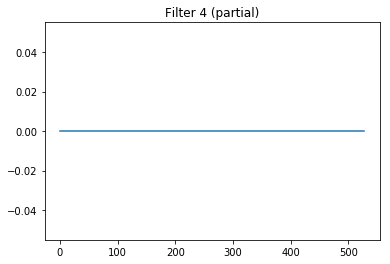

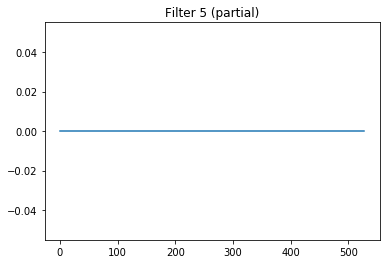

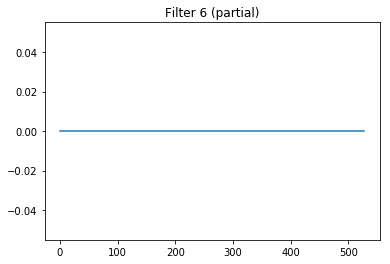

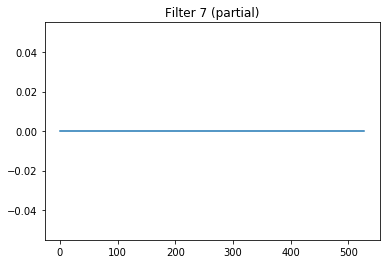

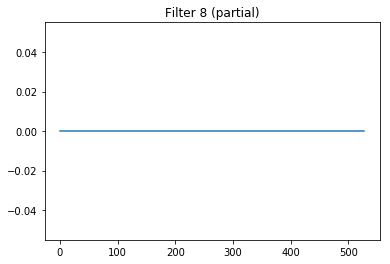

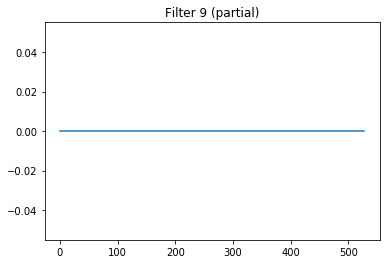

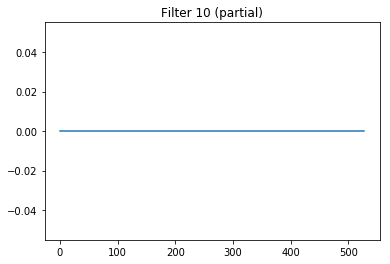

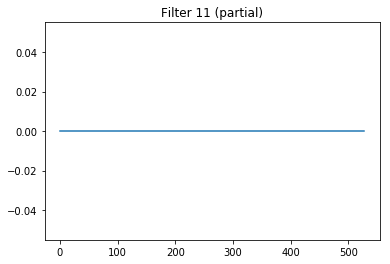

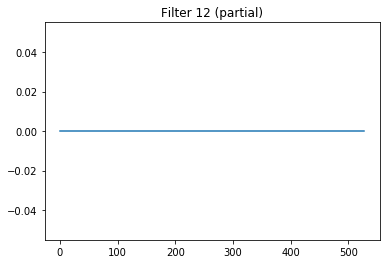

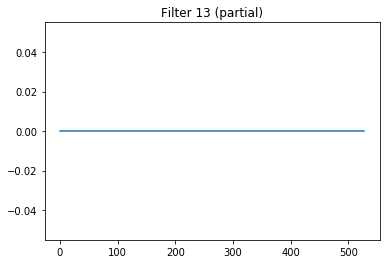

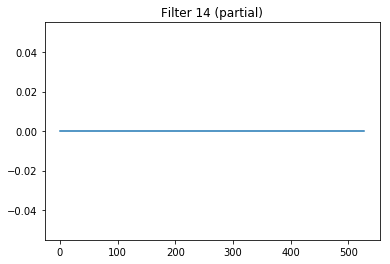

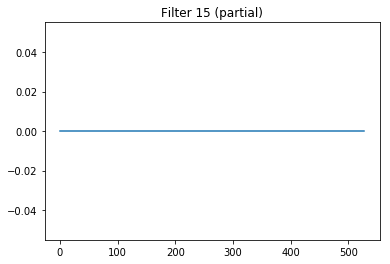

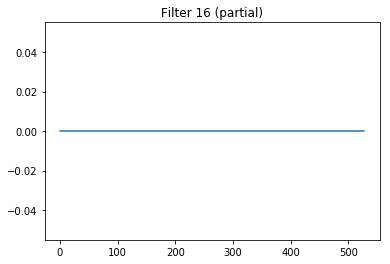

In [77]:
f = np.linspace(0, rate / 2, np.ceil((nfft + 1) / 2))
for idx in range(0, len(fbank)):
    plt.figure(idx)
    plt.title('Filter %d (partial)' % idx)
    plt.plot(f[0:50], fbank[idx][0:50])
plt.show()

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


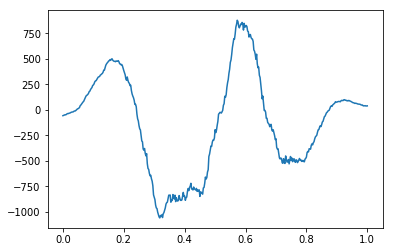

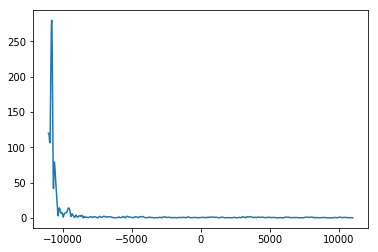

In [78]:
frame = frames[0]
Ws = 0.020
Ns = Ws * rate
lin = np.linspace(0, 1, Ns)
plt.plot(lin, frame)
plt.show()
Y = np.fft.fft(frame, nfft) / len(frame)
Z = abs(Y)
NUP = int(np.ceil((len(Y) + 1) / 2))
Z = Z[0:NUP]
f = rate * np.linspace(-0.5, 0.5, NUP)
plt.plot(f, Z)
plt.show()

In [79]:
Y = np.fft.rfft(frames, nfft)
Z = abs(Y)
NUP = int(np.ceil((len(Y) + 1) / 2))
Z = Z[0:NUP]

pow_frames = ((1.0 / nfft) * ((Z) ** 2))

In [80]:
filters = fbank
filter_banks = np.dot(pow_frames, filters.T)
# Estabilizar
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
signal_filtered = np.log10(filter_banks)
signal_filtered

array([[ 6.1862556 ,  5.09004909,  4.54978785, ...,  3.63255932,
         3.80071639,  3.72295626],
       [ 5.8505474 ,  5.16736179,  3.81350259, ...,  3.55905403,
         3.62212977,  3.58893005],
       [ 6.20643098,  5.41152381,  4.74811246, ...,  3.85191374,
         3.59719805,  3.51049465],
       ..., 
       [ 8.89149598,  9.11089808,  8.77278382, ...,  6.38339534,
         6.37840103,  6.65393951],
       [ 8.84805252,  8.92960759,  8.62556946, ...,  6.57183155,
         6.53089488,  6.86157125],
       [ 8.74682376,  8.52554905,  7.97548014, ...,  6.2974909 ,
         6.28767475,  6.85702534]])

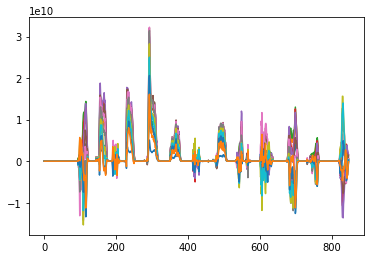

array([[  6.16413020e+05,   1.39428385e+06,   1.94122615e+06, ...,
          2.42106476e+06,   1.99803016e+06,   1.62981964e+06],
       [  3.09047065e+05,   6.92789336e+05,   9.70719623e+05, ...,
          8.18524137e+05,   6.66527408e+05,   5.19212350e+05],
       [  7.25646970e+05,   1.56865634e+06,   2.09971454e+06, ...,
          2.76138038e+06,   2.14894331e+06,   1.41684150e+06],
       ..., 
       [  1.04812368e+09,   1.36538203e+09,   1.15203001e+09, ...,
         -9.56241004e+08,  -1.42401257e+09,  -2.05992009e+09],
       [  7.69272653e+08,   1.08999107e+09,   9.58204270e+08, ...,
         -7.66666733e+08,  -8.91545714e+08,  -9.45024721e+08],
       [  3.94453544e+08,   5.89337763e+08,   5.83413392e+08, ...,
          3.63646738e+08,   2.24831999e+08,  -1.22488000e+08]])

In [81]:
cep_lifter = 17

mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1: (cep + 1)]  # Keep 2-13
(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift
plt.plot(mfcc)
plt.show()
mfcc

848


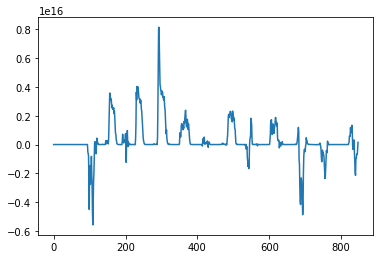

C:\ProgramData\Anaconda2\lib\site-packages\numpy\linalg\linalg.py:1804: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


-inf

In [82]:
from numpy.linalg import det
covariance = np.cov(mfcc)
print(len(mfcc))
plt.plot(covariance[0])
plt.show()
np.linalg.det(covariance)

In [6]:
import math
import numpy as np
from scipy.fftpack import dct
import numpy as np
import scipy.io.wavfile
import scipy.signal
import matplotlib.pyplot as plt
import os.path
import math
from __future__ import division


def _hz2mel(hz):
    """
    Convert frequency to Mel frequency.
    Arguments:
        hz:Frequency in Hz.
    Returns:
        Mel frequency.
    """
    return 2595 * np.log10(1 + hz / 700.0)


def _mel2hz(mel):
    """
    Convert Mel frequency to frequency.
    Arguments:
        mel:Mel frequency
    Returns:
        Frequency in Hz.
    """
    return 700 * (10**(mel / 2595.0) - 1)


def _spectrum_magnitude(frames, NFFT):
    '''
    Apply FFT and Calculate magnitude of the spectrum.
    Arguments:
        frames: 2-D frames array calculated by audio2frame(...).
        NFFT:FFT size.
    Returns:
        Return magnitude of the spectrum after FFT, with shape (frames_num, NFFT).
    '''
    complex_spectrum = np.fft.rfft(frames, NFFT)
    return np.absolute(complex_spectrum)


def _spectrum_power(frames, NFFT):
    """
    Calculate power spectrum for every frame after FFT.
    Arguments:
        frames: 2-D frames array calculated by audio2frame(...).
        NFFT:FFT size
    Returns:
        Power spectrum: PS = magnitude^2/NFFT
    """
    return 1.0/NFFT * np.square(_spectrum_magnitude(frames, NFFT))


def _pre_emphasis(signal, coefficient=0.95):
    '''
    Pre-emphasis.
    Arguments:
        signal: 1-D numpy array.
        coefficient:Coefficient for pre-emphasis. Defauted to 0.95.
    Returns:
        pre-emphasis signal.
    '''
    return np.append(signal[0], signal[1:] - coefficient * signal[:-1])


def _audio2frame(signal, frame_length, frame_step, win_func=lambda x:np.ones((x,))):
    """
    Framing audio signal. Uses numbers of samples as unit.
    Arguments:
        signal: 1-D numpy array.
        frame_length: In this situation, frame_length=sample_rate*win_length, since we use numbers of samples as unit.
        frame_step:In this situation, frame_step = sample_rate*win_step, 
                   representing the number of samples between the start point of adjacent frames.
        win_func:lambda function, to generate a vector with shape (x,) filled with ones.
    Returns:
        frames*win: 2-D numpy array with shape (frames_num, frame_length).
    """
    signal_length = len(signal)
    # Use round() to ensure length and step are integer, considering that we use numbers of samples as unit.
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    if signal_length <= frame_length:
        frames_num = 1
    else:
        frames_num = 1 + int(math.ceil((signal_length - frame_length) / frame_step))
    pad_length = int((frames_num - 1) * frame_step + frame_length)
    # Padding zeros at the end of signal if pad_length > signal_length.
    zeros = np.zeros((pad_length - signal_length, ))
    pad_signal = np.concatenate((signal, zeros))
    # Calculate the indices of signal for every sample in frames, shape (frams_nums, frams_length)
    indices = np.tile(np.arange(0, frame_length), (frames_num, 1)) + np.tile(np.arange(0, frames_num * frame_step, frame_step), 
                                                                             (frame_length, 1)).T
    indices = np.array(indices, dtype=np.int32)
    # Get signal data according to indices.
    frames = pad_signal[indices]
    win = np.tile(win_func(frame_length), (frames_num, 1))
    return frames*win


def _lifter(cepstra, L=22):
    '''
    Lifter function.
    Arguments:
        cepstra: MFCC coefficients.
        L: Numbers of lifters. Defaulted to 22.
    '''
    if L > 0:
        (nframes, ncoeff) = np.shape(cepstra)
        n = np.arange(ncoeff)
        lift = 1+(L/2)*np.sin(np.pi*n/L)
        return lift*cepstra
    else:
        return cepstra


def _get_filter_banks(filters_num=20, NFFT=512, sample_rate=16000, low_freq=0, high_freq=None):
    '''
    Calculate Mel filter banks.
    Arguments:
        filters_num: Numbers of Mel filters.
        NFFT:FFT size. Defaulted to 512.
        sample_rate: Sampling rate. Defaulted to 16KHz.
        low_freq: Lowest frequency.
        high_freq: Highest frequency.
    '''
    # Convert frequency to Mel frequency.
    low_mel = _hz2mel(low_freq)
    high_mel = _hz2mel(high_freq)
    # Insert filters_num of points between low_mel and high_mel. In total there are filters_num+2 points
    mel_points = np.linspace(low_mel, high_mel, filters_num + 2)
    # Convert Mel frequency to frequency and find corresponding position.
    hz_points = _mel2hz(mel_points)
    # Find corresponding position of these hz_points in fft.
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)
    # Build Mel filters' expression.First and third points of each filter are zeros.
    fbank = np.zeros([filters_num, int(NFFT / 2 + 1)])
    for j in range(0, filters_num):
        for i in range(int(bin[j]), int(bin[j+1])):
            fbank[j,i] = (i-bin[j]) / (bin[j+1]-bin[j])
        for i in range(int(bin[j+1]), int(bin[j+2])):
            fbank[j,i] = (bin[j+2]-i) / (bin[j+2]-bin[j+1])
    return fbank


def _fbank(signal, sample_rate=16000, win_length=0.025, win_step=0.01, filters_num=26,
           NFFT=512, low_freq=0, high_freq=None, pre_emphasis_coeff=0.97):
    """
    Perform pre-emphasis -> framing -> get magnitude -> FFT -> Mel Filtering.
    Arguments:
        signal: 1-D numpy array.
        sample_rate: Sampling rate. Defaulted to 16KHz.
        win_length: Window length. Defaulted to 0.025, which is 25ms/frame.
        win_step: Interval between the start points of adjacent frames.
            Defaulted to 0.01, which is 10ms.
        filters_num: Numbers of filters. Defaulted to 26.
        NFFT: Size of FFT. Defaulted to 512.
        low_freq: Lowest frequency.
        high_freq: Highest frequency.
        pre_emphasis_coeff: Coefficient for pre-emphasis. Pre-emphasis increase
            the energy of signal at higher frequency. Defaulted to 0.97.
    Returns:
        feat: Features.
        energy: Energy.
    """
    # Calculate the highest frequency.
    high_freq = high_freq or sample_rate / 2
    # Pre-emphasis
    signal = _pre_emphasis(signal, pre_emphasis_coeff)
    # frames: 2-D numpy array with shape (frame_num, frame_length)
    frames = _audio2frame(signal, win_length * sample_rate, win_step * sample_rate)
    # Caculate energy and modify all zeros to eps.
    spec_power = _spectrum_power(frames, NFFT)
    energy = np.sum(spec_power, 1)
    energy = np.where(energy==0, np.finfo(float).eps, energy)
    # Get Mel filter banks.
    fb = _get_filter_banks(filters_num, NFFT, sample_rate, low_freq, high_freq)
    # Get MFCC and modify all zeros to eps.
    feat = np.dot(spec_power, fb.T)
    feat = np.where(feat==0, np.finfo(float).eps, feat)

    return feat, energy


def _delta(feat, N=2):
    """
    Compute delta features from a feature vector sequence.
    Arguments:
        feat: A numpy array of size (NUMFRAMES by number of features) containing features.
        Each row holds 1 feature vector.
        N: For each frame, calculate delta features based on preceding and following N frames.
    Returns:
        A numpy array of size (NUMFRAMES by number of features) containing delta features.
        Each row holds 1 delta feature vector.
    """
    NUMFRAMES = len(feat)
    feat = np.concatenate(([feat[0] for i in range(N)], feat, [feat[-1] for i in range(N)]))
    denom = sum([2*i*i for i in range(1, N+1)])
    dfeat = []
    for j in range(NUMFRAMES):
        dfeat.append(np.sum([n*feat[N+j+n] for n in range(-1*N, N+1)], axis=0)/denom)
    return dfeat


def calcFbank(signal, sample_rate=16000, win_length=0.025, win_step=0.01,
             filters_num=26, NFFT=512, low_freq=0, high_freq=None, pre_emphasis_coeff=0.97,
             append_energy=True, append_delta=False):
    """
    Calculate Fbank Features.
    Arguments:
        signal: 1-D numpy array.
        sample_rate: Sampling rate. Defaulted to 16KHz.
        win_length: Window length. Defaulted to 0.025, which is 25ms/frame.
        win_step: Interval between the start points of adjacent frames.
            Defaulted to 0.01, which is 10ms.
        filters_num: Numbers of filters. Defaulted to 26.
        NFFT: Size of FFT. Defaulted to 512.
        low_freq: Lowest frequency.
        high_freq: Highest frequency.
        pre_emphasis_coeff: Coefficient for pre-emphasis. Pre-emphasis increase
            the energy of signal at higher frequency. Defaulted to 0.97.
        append_energy: Whether to append energy. Defaulted to True.
        append_delta: Whether to append delta to feature. Defaulted to False.
    Returns:
        2-D numpy array with shape (NUMFRAMES, features). Each frame containing filters_num of features.
    """
    (feat, energy) = _fbank(signal, sample_rate, win_length, win_step, filters_num, NFFT,
                           low_freq, high_freq, pre_emphasis_coeff)
    feat = np.log(feat)
    if append_energy:
        feat[:, 0] = np.log(energy)
    if append_delta:
        feat_delta = _delta(feat)
        feat_delta_delta = _delta(feat_delta)
        feat = np.concatenate((feat, feat_delta, feat_delta_delta), axis=1)

    return feat


def calcMFCC(signal, sample_rate=16000, win_length=0.025, win_step=0.01,
             filters_num=26, NFFT=512, low_freq=0, high_freq=None, pre_emphasis_coeff=0.97,
             cep_lifter=22, append_energy=True, append_delta=False):
    """
    Calculate MFCC Features.
    Arguments:
        signal: 1-D numpy array.
        sample_rate: Sampling rate. Defaulted to 16KHz.
        win_length: Window length. Defaulted to 0.025, which is 25ms/frame.
        win_step: Interval between the start points of adjacent frames.
            Defaulted to 0.01, which is 10ms.
        filters_num: Numbers of filters. Defaulted to 26.
        NFFT: Size of FFT. Defaulted to 512.
        low_freq: Lowest frequency.
        high_freq: Highest frequency.
        pre_emphasis_coeff: Coefficient for pre-emphasis. Pre-emphasis increase
            the energy of signal at higher frequency. Defaulted to 0.97.
        cep_lifter: Numbers of lifter for cepstral. Defaulted to 22.
        append_energy: Whether to append energy. Defaulted to True.
        append_delta: Whether to append delta to feature. Defaulted to False.
    Returns:
        2-D numpy array with shape (NUMFRAMES, features). Each frame containing filters_num of features.
    """
    (feat, energy) = _fbank(signal, sample_rate, win_length, win_step, filters_num, NFFT,
                           low_freq, high_freq, pre_emphasis_coeff)
    feat = np.log(feat)
    feat = dct(feat, type=2, axis=1, norm='ortho')
    feat = _lifter(feat, cep_lifter)
    if append_energy:
        feat[:, 0] = np.log(energy)
    if append_delta:
        feat_delta = _delta(feat)
        feat_delta_delta = _delta(feat_delta)
        feat = np.concatenate((feat, feat_delta, feat_delta_delta), axis=1)

    return feat


SAMPLE_DIR = 'audio_samples/'
files = next(os.walk(SAMPLE_DIR))[2]
files = list(files)

wavfile = SAMPLE_DIR + files[0]
rate, data = scipy.io.wavfile.read(wavfile)
print rate
signal_len = len(data)
print signal_len
res = calcFbank(data, rate, win_length=0.025, win_step=0.01,
             filters_num=26, NFFT=512, low_freq=0, high_freq=None, pre_emphasis_coeff=0.97,
             append_energy=True, append_delta=False)
print res
print res.shape

22050
374850
[[ 13.8268412   12.72798044  10.77904444 ...,  10.87648855  10.92007822
   10.93997595]
 [ 13.18964429  12.01409144  10.41130126 ...,  10.42846184  10.11141291
    9.96192353]
 [ 12.98531145  10.85529855  10.29501428 ...,  10.10676714  10.07419307
    9.83397084]
 ..., 
 [ 14.04606732  11.3120183   12.14103161 ...,  11.03595224  10.41299801
   10.35710687]
 [ 13.7305154   11.66574184  12.01049128 ...,  10.37971789  10.25965168
   10.39967693]
 [ 13.23487741  11.52472031  11.4846462  ...,   9.81325993   9.86798084
    9.86026666]]
(1695L, 26L)
